We use the official implementation of CRAFT available in the following link: https://github.com/deel-ai/Craft/tree/main

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from craft_evaluation import *
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet34(pretrained=True)
patch_size = 64 
rank = 25 

In [5]:
imagenet_class = 497

In [6]:
images_np = np.load('dataset/final_filtered_church_images.npz')['arr_0'].astype(np.uint8)

In [7]:
craft_class = craft_implementation(rank, imagenet_class, images_np, model, patch_size, device)

In [8]:
images_preprocessed = craft_class.preprocess_images(images_np)

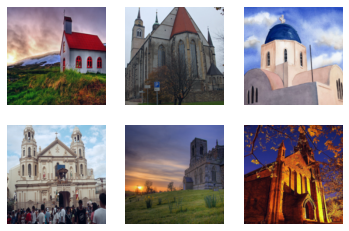

In [9]:
for i in range(6):
    img = images_preprocessed[i]
    img = np.array(img)
    img = img.transpose(1, 2, 0)
    img -= img.min()
    img /= img.max()
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [10]:
crops, crops_u, w, importances, images_u, craft = craft_class.compute_craft()

accuracy before NMF is: tensor(1.)
accuracy after NMF is: tensor(0.6205, device='cuda:0')


In [11]:
most_important_concepts = np.argsort(importances)[::-1][:5]

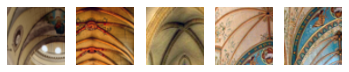

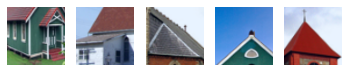

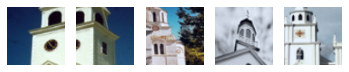

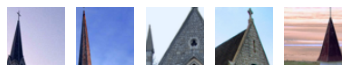

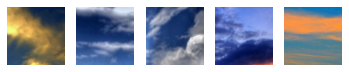

In [12]:
from math import ceil 
nb_crops = 5
def show(img, **kwargs):
  img = np.array(img)
  if img.shape[0] == 3:
    img = img.transpose(1, 2, 0)

  img -= img.min();img /= img.max()
  
  plt.imshow(img, **kwargs); plt.axis('off')
  

for c_id in most_important_concepts:
    best_crops_ids = np.argsort(crops_u[:, c_id])[::-1][:nb_crops]
    best_crops = crops[best_crops_ids]
    for i in range(nb_crops):
        plt.subplot(ceil(nb_crops/5), 5, i+1)
        
        show(best_crops[i])
    
    plt.show()
    print('\n\n')

#### Complexity

In [13]:
print('C_gini sparsity of concept importance:', craft_class.compute_gini_index(torch.tensor(importances)))

C_gini sparsity of concept importance: 0.7856647372245789


#### Faithfulness

In [14]:
W = torch.tensor(w)
images_u = craft.transform(images_preprocessed)
delete = craft_class.concept_deletion(images_u, w, W, importances)
insert = craft_class.concept_insertion(images_u, w, importances)

In [15]:
C_ins = craft_class.compute_insertion_auc(insert)
C_del = craft_class.compute_deletion_score(delete)

In [16]:
print('faithfulness using insertion AUC is ', C_ins)
print('faithfulness using deletion AUC is ', C_del)

faithfulness using insertion AUC is  0.6767342342342342
faithfulness using deletion AUC is  0.5261928620122057


#### NMF Projection Error 

In [17]:
mse_loss, kl_loss = craft_class.evaluate_nmf_projection(images_preprocessed, w, craft)
print('mse:', mse_loss)
print('KL:', kl_loss)

mse: 0.38637879490852356
KL: 0.6601709127426147


#### Sparsity of representation

In [18]:
craft_class.compute_sparsity(images_u)

0.5219010710716248

#### Stability|

In [19]:
w_list = craft_class.extract_w_list(k_folds=5)

In [20]:
craft_class.compute_stability(w_list)

0.8890562415122986